<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf-intro/2020-01-rnn-basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequences Basics

Example, some code and a lot of inspiration taken from: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [4]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc3


## Univariate Sequences

just one variable per time step

### Challenge

We have a known series of events, possibly in time and you want to know what is the next event. Like this

[10, 20, 30, 40, 50, 60, 70, 80, 90]

In [0]:
# univariate data preparation
import numpy as np

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [6]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# choose a number of time steps
n_steps = 3

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# summarize the data
list(zip(X, y))

[(array([10, 20, 30]), 40),
 (array([20, 30, 40]), 50),
 (array([30, 40, 50]), 60),
 (array([40, 50, 60]), 70),
 (array([50, 60, 70]), 80),
 (array([60, 70, 80]), 90)]

In [7]:
X

array([[10, 20, 30],
       [20, 30, 40],
       [30, 40, 50],
       [40, 50, 60],
       [50, 60, 70],
       [60, 70, 80]])

### Converting shapes

* one of the most frequent, yet most tedious steps
* match between what you have and what an interface needs
* expected input of RNN: 3D tensor with shape (samples, timesteps, input_dim)
* we have: (samples, timesteps)
* reshape on np arrays can do all that

In [8]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X

array([[[10],
        [20],
        [30]],

       [[20],
        [30],
        [40]],

       [[30],
        [40],
        [50]],

       [[40],
        [50],
        [60]],

       [[50],
        [60],
        [70]],

       [[60],
        [70],
        [80]]])

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.models import Sequential, Model

model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"))
model.add(Dense(units=1, name="Linear_Output"))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_Input (SimpleRNN)        (None, 50)                2600      
_________________________________________________________________
Linear_Output (Dense)        (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [10]:
EPOCHS = 1000

%time history = model.fit(X, y, epochs=EPOCHS, verbose=0)

CPU times: user 3.31 s, sys: 191 ms, total: 3.5 s
Wall time: 2.69 s


In [11]:
loss = model.evaluate(X, y, verbose=0)
loss

2.464711315042223e-06

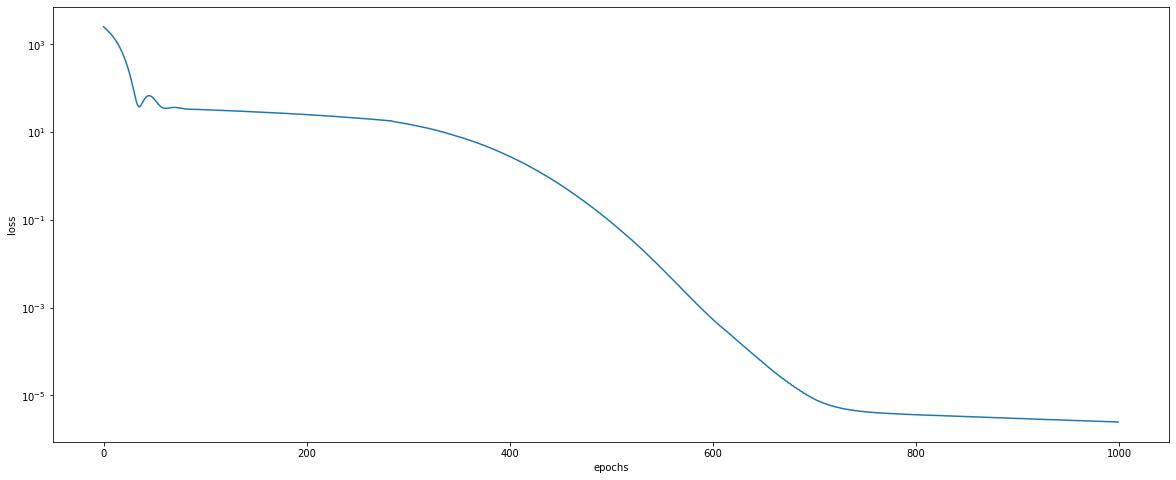

In [12]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss']);

### Let's try this on a few examples

In [13]:
# this does not look too bad
X_sample = np.array([[10, 20, 30], [70, 80, 90]]).astype(np.float32)
X_sample = X_sample.reshape((X_sample.shape[0], X_sample.shape[1], n_features))
X_sample

array([[[10.],
        [20.],
        [30.]],

       [[70.],
        [80.],
        [90.]]], dtype=float32)

In [14]:
y_pred = model.predict(X_sample)
y_pred

array([[ 39.997524],
       [100.56422 ]], dtype=float32)

In [0]:
def predict(model, samples, n_features=1):
  input = np.array(samples).astype(np.float32)
  input = input.reshape((input.shape[0], input.shape[1], n_features))
  y_pred = model.predict(input)
  return y_pred

In [16]:
# do not look too close, though
predict(model, [[100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[132.31868],
       [239.33394],
       [485.558  ]], dtype=float32)

## Exercise

* go through the notebook as it is
* Try to improve the model
  * Change the number of values used as input
  * Change activation function
  * More nodes? less nodes?
  * What else might help improving the results?


# STOP HERE

### Input and output of an RNN layer

In [17]:
# https://keras.io/layers/recurrent/
# input: (samples, timesteps, input_dim)
# output: (samples, units)

# let's have a look at the actual output for an example
rnn_layer = model.get_layer("RNN_Input")
model_stub = Model(inputs = model.input, outputs = rnn_layer.output)
hidden = predict(model_stub, [[10, 20, 30]])
hidden.shape, hidden

((1, 50), array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         1.4743265e+01, 8.1255512e+00, 0.0000000e+00, 0.0000000e+00,
         6.7234039e-05, 0.0000000e+00, 0.0000000e+00, 2.8233912e+00,
         5.1604357e+00, 0.0000000e+00, 5.4678979e+00, 1.9486965e+01,
         0.0000000e+00, 1.0877475e+01, 0.0000000e+00, 1.5711739e+01,
         6.8957291e+00, 1.6780807e+01, 4.6541147e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 3.0816078e-02, 8.2897730e+00, 6.8407588e+00,
         1.0221004e+01, 0.0000000e+00, 0.0000000e+00, 1.2385271e+00,
         8.0166082e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         1.8420826e+01, 7.0471430e-01, 0.0000000e+00, 5.5695000e+00,
         0.0000000e+00, 0.0000000e+00, 8.3999662e+00, 6.6061492e+00,
         7.6293945e-05, 0.0000000e+00]], dtype=float32))

#### What do we see?
* each unit (50) has a single output
* as a sidenote you nicely see the RELU nature of the output
* so the timesteps of the input are lost
* we are only looking at the final output
* still with each timestep, the layer does produce a unique output we could potentially use

### We need to look into RNNs a bit more deeply now

#### RNNs - Networks with Loops
<img src='https://djcordhose.github.io/ai/img/nlp/colah/RNN-rolled.png' height=200>

http://colah.github.io/posts/2015-08-Understanding-LSTMs/
#### Unrolling the loop
<img src='https://djcordhose.github.io/ai/img/nlp/colah/RNN-unrolled.png'>

http://colah.github.io/posts/2015-08-Understanding-LSTMs/
#### Simple RNN internals

<img src='https://djcordhose.github.io/ai/img/nlp/fchollet_rnn.png'>

##  $output_t = \tanh(W input_t + U output_{t-1} + b)$

From Deep Learning with Python, Chapter 6, François Chollet, Manning: https://livebook.manning.com/#!/book/deep-learning-with-python/chapter-6/129

#### Activation functions

<img src='https://djcordhose.github.io/ai/img/sigmoid-activation.png' height=200>

Sigmoid compressing between 0 and 1

<img src='https://djcordhose.github.io/ai/img/tanh-activation.png' height=200>

Hyperbolic tangent, like sigmoind, but compressing between -1 and 1, thus allowing for negative values as well